# Tutorial 1b: High- and low-level plotting

(c) 2018 Justin Bois. With the exception of pasted graphics, where the source is noted, this work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

This document was prepared at [Caltech](http://www.caltech.edu) with financial support from the [Donna and Benjamin M. Rosen Bioengineering Center](http://rosen.caltech.edu).

<img src="caltech_rosen.png">


*This tutorial was generated from an Jupyter notebook.  You can download the notebook [here](t1b_plotting.ipynb).*

In [1]:
import numpy as np
import pandas as pd

import bebi103

import altair as alt

import bokeh.plotting
import bokeh.io

bokeh.io.output_notebook()

Loading BokehJS ...

Now that you know how to load in a data set and manipulate it using Pandas, lets move on to **display** of data. We will start with the data form the [Kleinteich and Gorb](https://dx.doi.org/10.1038%2Fsrep05225) paper we used in the last tutorial on frog strikes. We'll start by reading the data into a data frame and also adding in the metadata as in the last tutorial.

In [2]:
df = pd.read_csv('../data/frog_tongue_adhesion.csv', comment='#')

data_dict = {'ID': ['I', 'II', 'III', 'IV'],
             'age': ['adult', 'adult', 'juvenile', 'juvenile'],
             'SVL (mm)': [63, 70, 28, 31],
             'weight (g)': [63.1, 72.7, 12.7, 12.7],
             'species': ['cross', 'cross', 'cranwelli', 'cranwelli']}

df = df.merge(pd.DataFrame(data=data_dict))

# Check it out!
df.head()

date ID  trial number  impact force (mN)  impact time (ms)  \
0  2013_02_26  I             3               1205                46   
1  2013_02_26  I             4               2527                44   
2  2013_03_01  I             1               1745                34   
3  2013_03_01  I             2               1556                41   
4  2013_03_01  I             3                493                36   

   impact force / body weight  adhesive force (mN)  \
0                        1.95                 -785   
1                        4.08                 -983   
2                        2.82                 -850   
3                        2.51                 -455   
4                        0.80                 -974   

   time frog pulls on target (ms)  adhesive force / body weight  \
0                             884                          1.27   
1                             248                          1.59   
2                             211                          1.37   
3                            1025                          0.74   
4                             499                          1.57   

   adhesive impulse (N-s)  total contact area (mm2)  \
0                  -0.290                       387   
1                  -0.181                       101   
2                  -0.157                        83   
3                  -0.170                       330   
4                  -0.423                       245   

   contact area without mucus (mm2)  \
0                                70   
1                                94   
2                                79   
3                               158   
4                               216   

   contact area with mucus / contact area without mucus  \
0                                               0.82      
1                                               0.07      
2                                               0.05      
3                                               0.52      
4                                               0.12      

   contact pressure (Pa)  adhesive strength (Pa)    age  SVL (mm)  weight (g)  \
0                   3117                   -2030  adult        63        63.1   
1                  24923                   -9695  adult        63        63.1   
2                  21020                  -10239  adult        63        63.1   
3                   4718                   -1381  adult        63        63.1   
4                   2012                   -3975  adult        63        63.1   

  species  
0   cross  
1   cross  
2   cross  
3   cross  
4   cross

Now that we have a data set ready for use, let's start working on plotting.

## High-level and low-level plotting packages

Now, say we want to make a plot of some data. You can imagine that there are many many steps to building that. One way you could build a plot is to hand-generate an [SVG file](https://en.wikipedia.org/wiki/Scalable_Vector_Graphics) that is a set of specifications for lines and circles and text and whatnot that comprises a plot. (I have actually done this before, writing a C program that hand-generated SVG, and it was paaaaainful.) That would be a very **low-level** way of generating a plot. Plotting libraries in Python usually take care of the rendering part for you, either rendering the plot as SVG, PDF, PNG, or other formats, including interactive ones that use [JavaScript](https://en.wikipedia.org/wiki/JavaScript) and [HTML Canvas](https://en.wikipedia.org/wiki/Canvas_element) that can be viewed in a browser. The plotting libraries then vary in their level of abstraction from the data set.

**Lower-level plotting** libraries typically are more customizable, but require more [**boilerplate code**](https://en.wikipedia.org/wiki/Boilerplate_code) to get your data plotted and are therefore more cumbersome. **Higher-level plotting** libraries aim to make it easier to move directly from a `DataFrame`. Because of this streamlining, though, they are often more difficult to customize.

## The Python visualization landscape

There are many, many plotting packages available in Python. In a [talk at PyCon in 2017](https://www.youtube.com/watch?v=FytuB8nFHPQ), [Jake VanderPlas](http://vanderplas.com), who is one of the authors of [Altair](https://altair-viz.github.io), the main high-level plotting package we'll use in this class, gave an overview of the Python visualization landscape. That landscape is depicted below, taken from [this visualization of it](https://github.com/rougier/python-visualization-landscape) by [Nicolas Rougier](http://www.labri.fr/perso/nrougier/).

![python_viz_landscape](python_viz_landscape.png)

The landscape is divided into three main pods based on the low-level renderer of the graphics, JavaScript, [Matplotlib](https://matplotlib.org), and [OpenGL](https://www.opengl.org) (though Matplotlib is higher-level than JavaScript and OpenGL). We will not discuss packages based on OpenGL. Packages that use JavaScript for rendering are particularly well suited for interactivity in browsers. Interactivity and portability (accomplished by rendering in browsers) are key features of modern plotting libraries, so we will use primarily JavaScript-based plotting (as I do in my own work).

The main high-level plotting package we will use is [Altair](https://altair-viz.github.io). It uses the [Vega/Vega-Lite](https://vega.github.io) visualization grammars, which interface to [d3.js](https://d3js.org), a fantastic library for interactive visualizations based on JavaScript. (The connection shown by the dashed line between Altair and Matplotlib is not really there any more.) Our major motivation for choosing Altair is that its grammar is clean and consistent. It also has good JupyterLab integration. This provides a good framework for building graphics.

For our low-level plotting, which we will occasionally have to do, especially for images, we will use [Bokeh](https://bokeh.pydata.org/), a newer library for generating interactive plots. Its grammar is clean, it has good documentation, and it being adapted for widespread use. We will get to this in the second half of this tutorial. But first, on to Altair and high-level plotting.

## Plotting with Altair

Altair uses a [declarative paradigm](https://en.wikipedia.org/wiki/Declarative_programming), meaning that you tell Altair what *you want* as opposed to telling it what *to do*. For example, let's say I want to make a scatter plot of adhesive force versus impact force. Note that we have imported Altair as `alt`.

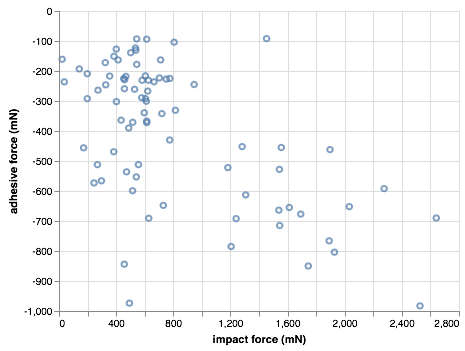

In [3]:
alt.Chart(df).mark_point().encode(x='impact force (mN)', y='adhesive force (mN)')

In looking at the above syntax, remember that after each dot (except the first one) is a method associated with the object that was created. In this way, the plot was built in steps.

1. `alt.Chart(df)` created a `Chart` object whose underlying data are in the `DataFrame` `df`.
2. `.mark_point()` specifies that the **marks** on the chart are points.
3. `.encode(x='impact force (mN)', y='adhesive force (mN)')` says that the positions of the points on the chart are encoded according to the `impact force (mN)` and `adhesive force (mN)` columns of the data frame.

This is very much like English.
> "Altair, give my a plot of data from my data frame where the data are plotted as points, and the x-values are the impact forces and the y-values are the adhesive forces."

Altair took care of the rest, like specifying plot dimensions, labeling the axes, setting their ranges, stylizing the grid, etc. These can be adjusted, but at its basic level, this is how Altair makes a plot.

### The importance of tidy data frames

Given how Altair interpreted our commands, it might be clear for you now that Altair requires a certain arrangement for your data. Specifically, the data frame must be **tidy**, which we will learn about in the tutorials next week. For now, it suffices to know that we are, in fact, working with a tidy data frame.

### Code style in plot specifications

Specifications of Altair plots involve lots of **method chaining** and can get unwieldy without a clear style. You can develop your own style, maybe reading [Trey Hunner's blog post again](http://treyhunner.com/2017/07/craft-your-python-like-poetry/). I like to do the following.

1. Put the `alt.Chart(df` on the first line.
2. The closed parenthesis of the preceding line is one indentation level in.
3. Any arguments of subsequent functions are given as kwargs two indentation levels in.

Here's an example for the chart we just created, where I also assign the chart to a variable, and then ask Jupyter to display the chart by reference to the variable.

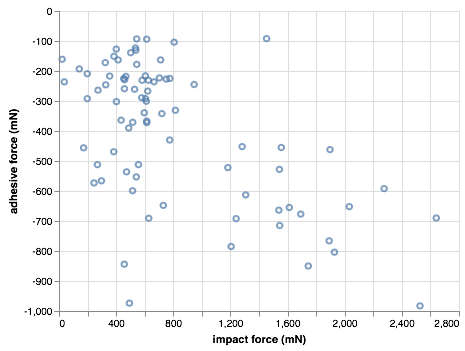

In [4]:
chart = alt.Chart(df
    ).mark_point(
    ).encode(
        x='impact force (mN)', 
        y='adhesive force (mN)'
    )

chart

If you adhere to a style, it makes your code cleaner and easier to read.

### Altair data types

When making a plot, we should specify the type of data we are encountering. For example, the `impact force (mN)` column consists of `float`s, so these are **quantitative**. (They are actually `int`s, but should be treated as floats.) By contrast, the `species` column consists of only one of two strings, `'cross'` and `'cranwelli'`. This column contains **nominative** data. The `trail number` column consists of trial numbers (duh), which can only take integer values. These data are not quantitative (in the sense of classifying data types), since they are discrete. Unlike the `'species'` column, they do have an ordering, so the `'trial number'` column contains **ordinal** data. Altair has a fourth data type, **temporal** which is used to describe columns in a data frame that have information about time.

Each data type has a shorthand that can be used in the specification. Here is a summary of the data types and their shorthand, taken largely from [Altair's docs](https://altair-viz.github.io/user_guide/encoding.html#data-types)

|Data Type|Shorthand Code|Description|
|:-- |:-- |:-- |
|quantitative|`Q`|continuous, real|
|ordinal|`O`|discrete, ordered|
|nominal|`N`|discrete, unordered category|
|temporal|`T`|time|

We can use the shorthand to specify data types by adding, e.g., `:Q` for quantitative data in an encoding. For example, a more complete specification for our plot is as follows (the output is the same, since Altair assumed a quantitative data type, but you should in general never count on Altair's inferences, but specify the data type yourself). So, here's a little rule, **always specify the data type in your encoding**.

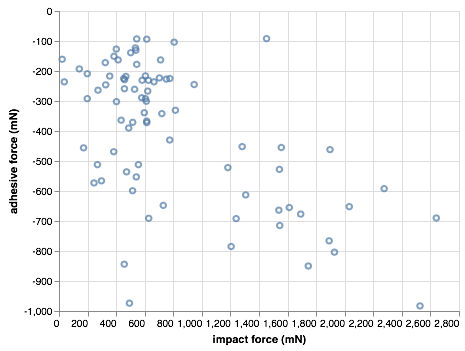

In [5]:
alt.Chart(df
    ).mark_point(
    ).encode(
        x='impact force (mN):Q', 
        y='adhesive force (mN):Q'
    )

### A watch-out about column names

Because of [Vega's specifications](https://vega.github.io/vega-lite/docs/field.html), Altair will not interpret brackets, dots, quotes, or percent signs in field names. That means that if you have a column in a data frame that has one of those characters, you will need to change the name of the column so that it does not have those characters. For example, you might have a column representing the concentration of a chemical, like `[IPTG] (mM)`. In this case, you can use
```python
df = df.rename(columns={'[IPTG] (mM)': 'iptg conc (mM)'})
```
to rename the appropriate column. You can then proceed to use the data frame in Altair, but you will need to be explicit about the axis label, encoding with something like
```python
alt.X('iptg conc (mM)', title='[IPTG] (mM)')
```

### Altair marks

To specify the marks in an Altair chart, we use syntax like `mark_point()` or `mark_line()` to specify how the marks in the chart should appear. These take kwargs to customize the ticks. For example, if we wanted to make a **strip plot** of the impact forces, we can use `mark_tick`, and I will use the `opacity` kwarg to make the ticks semi-transparent so I can better look at overlap.

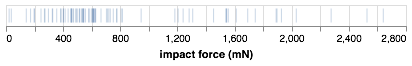

In [6]:
alt.Chart(df
    ).mark_tick(
        opacity=0.3
    ).encode(x='impact force (mN):Q'
    )

There are many marks, and they can be found in [Altair's docs](https://altair-viz.github.io/user_guide/marks.html#marks).

### Altair encodings

An **encoding** maps properties of the data to visual properties. In the first plot we made, we mapped the impact force to the x-position of a mark. We call a mapping of data to a visual property an **encoding channel**. The channel I just described is an `x` channel. There are many more visual properties besides position of marks. You can find a complete list in the [Altair docs](https://altair-viz.github.io/user_guide/encoding.html#encoding-channels). `color` is a very commonly used encoding. We can use it to color the points with the age of the frog.

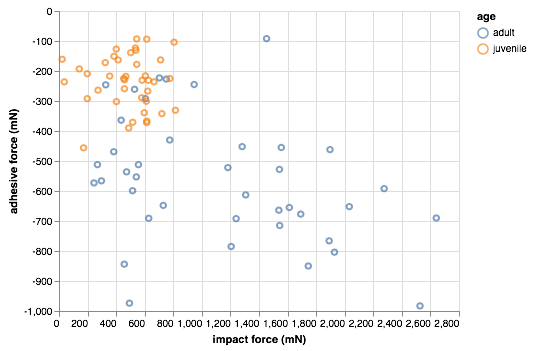

In [7]:
alt.Chart(df
    ).mark_point(
    ).encode(
        x='impact force (mN):Q', 
        y='adhesive force (mN):Q',
        color='age:N'
    )

Notice that Altair automatically did the coloring and made a legend for you.

Also note that if you hover your mouse over points in the plot (this will not work in the HTML version of the notebook, only if launched in JupyterLab), you can see information about each of the encodings, the impact force, adhesive force, and age. These useful bubbles with information are called **tooltips**.

### More control without shortcuts

So far, we used shortcuts for the encoding channels. That is, we passed the string `'impact force (mN):Q'` for the `x` channel. The shorthand is really convenient, but if we want more control over the plot, we should use the class associated with a given channel. You can refer again to the [Altair docs]([Altair docs](https://altair-viz.github.io/user_guide/encoding.html#encoding-channels) for the classes associated with each encoding channel. The class for the `x` channel is `alt.X`. `alt.X()` can take make kwargs, and you can use these to specify properties about how data are mapped to visual features on the plot. Similarly, `alt.Color()` enables you to set properties about coloring. 

To see how these work, let's make the same plot, except with the x-axis on a logarithmic scale and with the title of the legend omitted, since it is obvious what "adult" and "juvenile" mean.

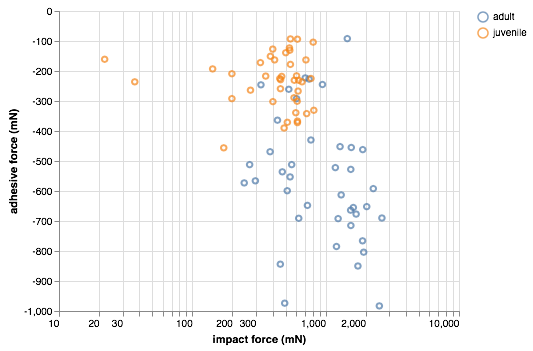

In [8]:
alt.Chart(df
    ).mark_point(
    ).encode(
        x=alt.X('impact force (mN)',
                type='quantitative',
                scale=alt.Scale(type='log')),
        y=alt.Y('adhesive force (mN)',
                type='quantitative'),
        color=alt.Color('age:N',
                        title=None)
    )

By default, Altair places the origin for positive data at zero. This can lead to some plots that might not look how you wish. To fix this, you can use the `zero=False` kwarg in setting up the scale of your axis.

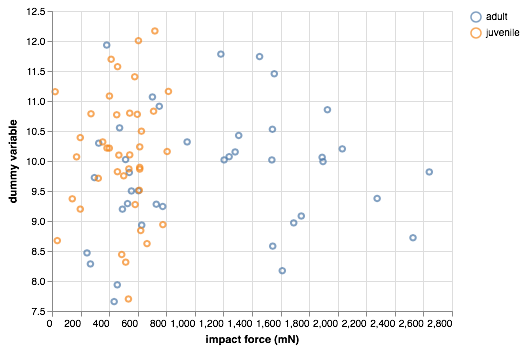

In [9]:
df['dummy variable'] = np.random.normal(10, 1, size=80)

alt.Chart(df
    ).mark_point(
    ).encode(
        x='impact force (mN):Q',
        y=alt.Y('dummy variable:Q', scale=alt.Scale(zero=False)),
        color=alt.Color('age:N',
                        title=None)
    )

### Composing charts

Altair allows you to easily make subplots. For example, if we want to have two plots side-by-side, we use the `|` operator.

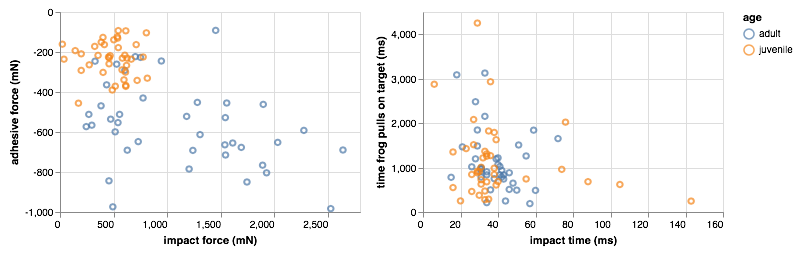

In [10]:
left_chart = alt.Chart(df,
        height=200,
        width=300
    ).mark_point(
    ).encode(
        x='impact force (mN):Q', 
        y='adhesive force (mN):Q',
        color='age:N'
    )

right_chart = alt.Chart(df,
        height=200,
        width=300
    ).mark_point(
    ).encode(
        x='impact time (ms):Q', 
        y='time frog pulls on target (ms):Q',
        color='age:N'
    )

left_chart | right_chart

The following operators are used to compose charts.

| operator       | result      | equivalent expression |
| :-------------: |:-------------|:----------------|
| `+`      | overlay | `alt.layer(chart1, chart2)` |
| ❘     | display side-by-side      | `alt.hconcat(chart1, chart2)` |
| `&` | display stacked vertically      | `alt.vconcat(chart1, chart2)`|

We can use this composition to create informative plots, like a **dash-dot plot**.

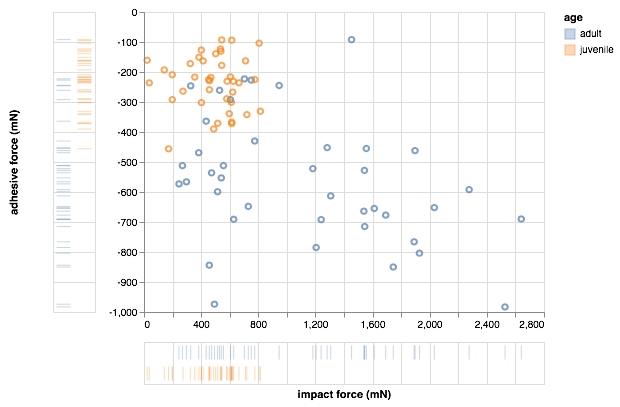

In [11]:
tick_axis = alt.Axis(labels=False, domain=False, ticks=False)
tick_axis_notitle = alt.Axis(labels=False, domain=False, ticks=False, title=None)

points = alt.Chart(df
    ).mark_point(
    ).encode(
        x=alt.X('impact force (mN):Q', title=None),
        y=alt.Y('adhesive force (mN):Q', title=None),
        color='age:N'
    )

x_ticks = alt.Chart(df
    ).mark_tick(
        opacity=0.3
    ).encode(
        alt.X('impact force (mN):Q', axis=tick_axis),
        alt.Y('age:N', axis=tick_axis_notitle),
        color='age:N'
    )

y_ticks = alt.Chart(df
    ).mark_tick(
        opacity=0.3
    ).encode(
        alt.X('age:N', axis=tick_axis_notitle),
        alt.Y('adhesive force (mN):Q', axis=tick_axis),
        color='age:N'
    )

y_ticks | (points & x_ticks)

In addition to manually composing charts, Altair allows **faceting** and **repeating**. To see how faceting works, let's assume we want to make separate plots of adhesive force versus impact force for juveniles and adults.

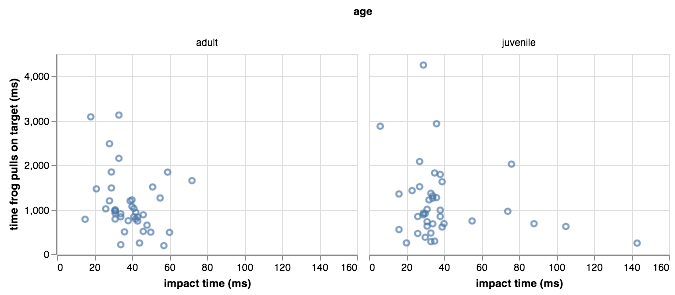

In [12]:
alt.Chart(df,
        height=200,
        width=300
    ).mark_point(
    ).encode(
        x='impact time (ms):Q', 
        y='time frog pulls on target (ms):Q',
    ).facet(
        column='age:N'
    )

Note that when using `facet()`, the ranges of the axes on the plots are linked.

Similarly, we may wish to repeat various axes to plot against.

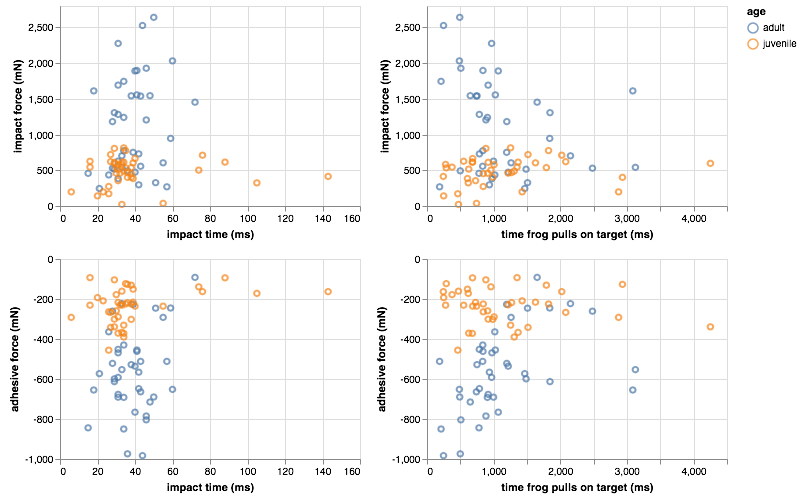

In [13]:
alt.Chart(df,
        height=200,
        width=300
    ).mark_point(
    ).encode(
        x=alt.X(alt.repeat("column"), type='quantitative'),
        y=alt.Y(alt.repeat("row"), type='quantitative'),
        color='age:N'
    ).repeat(
        row=['impact force (mN)', 'adhesive force (mN)'],
        column=['impact time (ms)', 'time frog pulls on target (ms)']
    )

### Interactive plotting with Altair

To make a plot interactive, which allows zooming and in and and other actions, you can simply add `.interactive()` to your chained functions. The interactivity works in JupyterLab, but does not currently work when the Jupyter notebook is exported to HTML (so if you are reading the HTML version of this document, you are only seeing static plots), but if you save the plot as HTML (see below), the interactivity is retained. When interactive, you can use your mouse wheel to zoom and you can also pan.

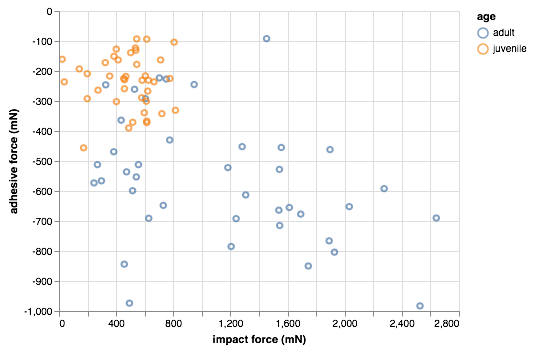

In [14]:
alt.Chart(df
    ).mark_point(
    ).encode(
        x='impact force (mN):Q', 
        y='adhesive force (mN):Q',
        color='age:N'
    ).interactive()

You can also specify additional **tooltips**. For example, we might like to know the ID of the frog, and also impact time. We can add this with a `tooltip` encoding. Note, though, that if we explicitly add the tooltips using the `tooltip` kwarg, the default tooltips (in this case  the impact force, adhesive force, and age) are not automatically included.

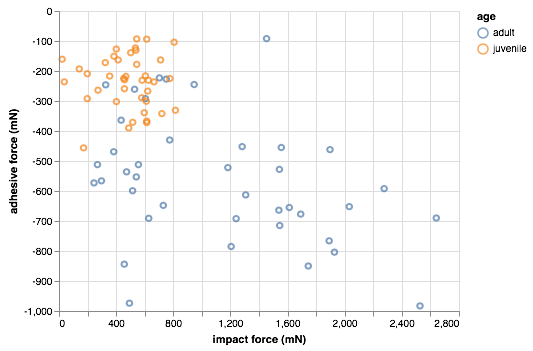

In [15]:
alt.Chart(df
    ).mark_point(
    ).encode(
        x='impact force (mN):Q', 
        y='adhesive force (mN):Q',
        color='age:N',
        tooltip=['ID', 'impact time (ms)']
    )

### Top-level properties 

We may also want to set some global, or top-level, properties of the plot, such as its height and width (which are specified in units of pixels), label font size and weight, etc. These things can be adjusted using the `configure_*()` methods (see [Altair docs](https://altair-viz.github.io/user_guide/configuration.html)). Again, let's learn by example.

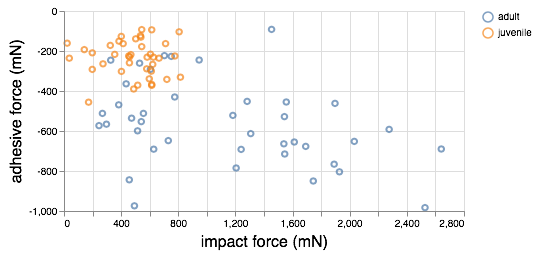

In [16]:
alt.Chart(df
    ).mark_point(
    ).encode(
        x='impact force (mN):Q',
        y='adhesive force (mN):Q',
        color=alt.Color('age:N',
                        title=None)
    ).configure_view(
        height=200,
        width=400
    ).configure_axis(
        titleFontSize=16,
        titleFontWeight='normal'
    )

The Altair documentation is very good, and you can usually find what configuration you would need in there.

### The less idiomatic way to do it

Instead of using method chaining, we can make specifications about the plot by passing properties about the marks, encodings, and views directly to `alt.Chart()` as constructor attributes.

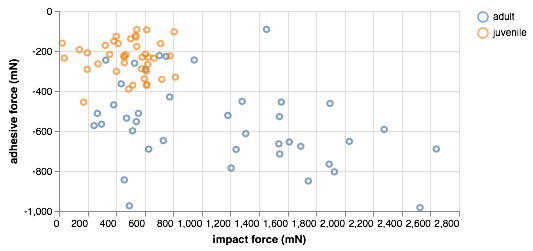

In [17]:
alt.Chart(data=df, 
          height=200,
          width=400,
          mark='point', 
          encoding=dict(x=alt.X('impact force (mN):Q'),
                        y=alt.Y('adhesive force (mN):Q'),
                        color=alt.Color('age:N', title=None))
         )

You will almost never use this mode of specifying plots, but it is useful to know that you can construct dictionaries that specify encodings when we use the [altair-catplot](https://github.com/justinbois/altair-catplot) module next week.

## Plotting (long) time series data

So far, we have seen how to plot measured data. One class of measured data we have not considered is time series data. Time series data are typically not plotted as points, but rather with joined lines. To get some experience plotting data sets like this, we will use some data from [Markus Meister](https://meisterlab.caltech.edu)'s group, collected by graduate students Dawna Bagherian and Kyu Lee. They put electrodes in the retinal cells of a mouse and measured voltage. From the time trace of voltage, they can detect and characterize spiking events. The first column of the CSV file is the time in milliseconds (ms) that the measurement was taken, and the second column is the voltage in units of microvolts (µV). Let's load in the data.

In [18]:
df_spike = pd.read_csv('../data/retina_spikes.csv', comment='#')

df_spike.head()

t (ms)  V (uV)
0  703.96    4.79
1  704.00   -0.63
2  704.04    5.83
3  704.08    0.31
4  704.12   -4.58

To make a plot of these data, we choose `mark_line()`. You may be tempted to specify that the data type of `x` is temporal. You really only want to do that if the data are time (like hours, minutes, seconds) and/or dates. You should still specify the data type of `x` to be quantitative.

In [19]:
alt.Chart(df_spike,
        height=200,
        width=500
    ).mark_line(
    ).encode(
        x='t (ms):Q',
        y=alt.Y('V (uV):Q', title='V (µV)')
    )

MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000). For information on how to plot larger datasets in Altair, see the documentation

Chart({
  data:         t (ms)  V (uV)
  0       703.96    4.79
  1       704.00   -0.63
  2       704.04    5.83
  3       704.08    0.31
  4       704.12   -4.58
  5       704.16   21.67
  6       704.20    8.13
  7       704.24    5.94
  8       704.28   14.79
  9       704.32    2.71
  10      704.36    0.94
  11      704.40   17.40
  12      704.44   11.77
  13      704.48   -2.60
  14      704.52    6.04
  15      704.56   -3.44
  16      704.60   -6.04
  17      704.64   10.42
  18      704.68   19.06
  19      704.72    7.40
  20      704.76    9.79
  21      704.80   20.42
  22      704.84   -0.10
  23      704.88   -7.92
  24      704.92   -7.29
  25      704.96  -11.25
  26      705.00  -12.19
  27      705.04   12.60
  28      705.08   -1.98
  29      705.12  -10.31
  ...        ...     ...
  19971  1502.80  -11.04
  19972  1502.84   -2.92
  19973  1502.88   -6.46
  19974  1502.92  -11.98
  19975  1502.96   -2.40
  19976  1503.00   -2.81
  19977  1503.04  -16.67
  19978  15

Wait! What happend? Altair threw an exception that the data set was too large to generate a plot. The [Altair docs](https://altair-viz.github.io/user_guide/faq.html#why-does-altair-lead-to-such-extremely-large-notebooks) explain why this is.

>This is not because Altair cannot handle larger datasets, but it is because it is important for the user to think carefully about how large datasets are handled. As noted above in Why does Altair lead to such extremely large notebooks?, it is quite easy to end up with very large notebooks if you make many visualizations of a large dataset, and this error is a way of preventing that.

### Handling large data sets with Altair

You will likely bump up against this in your work if you have large data sets. The [docs](https://altair-viz.github.io/user_guide/faq.html#maxrowserror-how-can-i-plot-large-datasets) give several ways to handle large data sets. Passing by URL is your best option, in my opinion. All you need to do to enable this is to include this line of code at the top of your notebook (or anywhere before you need to make a plot of a lot of data).
```python
alt.data_transformers.enable('json')
```
After you do that, you just use exactly the same plotting code as you would without it, except now the large data sets are easily handled. If this is enabled, every time you make a plot, a new [JSON document](https://en.wikipedia.org/wiki/JSON) is created externally to your notebook. Altair then references this document. This keeps your notebook size down and results in better performance. There are a couple of important watchouts for doing this, though.
1. Every time you make a plot, or even re-run a cell to make the same plot again, a new JSON file is created. (Future versions of Altair will probably have hashes that will prevent it from making new files if re-making a plot.) This can result in lots of JSON files in your directory. You should occasionally clean these out.
2. In some earlier versions of the JupyterLab extension for Bokeh (which we will use later in this tutorial) messes with the way JupyterLab routes URL paths, as described in [this issue on the Altair GibHub page](https://github.com/altair-viz/altair/issues/927) and [this one on the `jupyterlab_bokeh` page](https://github.com/bokeh/jupyterlab_bokeh/issues/42). This issue seems to be fixed, but may affect you for different versions/architectures.

### Trying again with a smaller data set

Instead of using URL referencing and to keep the notebook size down, we will take a smaller data set. We only consider times less than 750 ms.

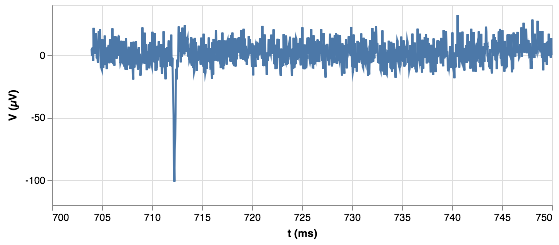

In [20]:
df_spike = df_spike.loc[df_spike['t (ms)'] < 750, :]

alt.Chart(df_spike,
        height=200,
        width=500
    ).mark_line(
    ).encode(
        x='t (ms):Q',
        y=alt.Y('V (uV):Q', title='V (µV)')
    )

We see a spike clearly resolved.

### Encoding the order

Remember that there is no inherent order to the entries in a `DataFrame`. Altair tries to be clever when making line plots as to the order in which the points are connected. Specifically, it assumes that the lines should be connected such that the `x` values are sorted. This often works fine, but what if we wanted to plot the trace with time on the y-axis and voltage on the x-axis? Let's try it.

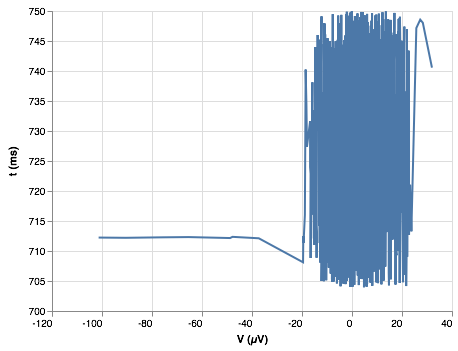

In [21]:
alt.Chart(df_spike
    ).mark_line(
    ).encode(
        y=alt.Y('t (ms):Q', scale=alt.Scale(zero=False)),
        x=alt.X('V (uV):Q', title='V (µV)')
    )

This plot is clearly messed up. That is because Altair connected the lines in order of voltage. To prevent this, we can use the `order` kwarg of `encode()` to make sure the points are connected in the proper order.

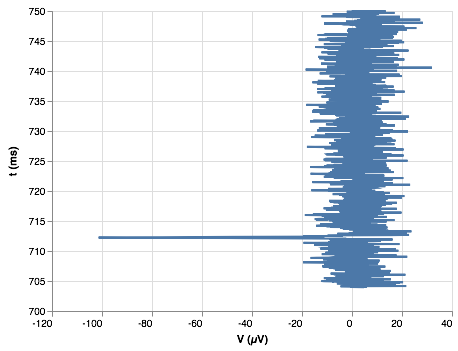

In [22]:
alt.Chart(df_spike
    ).mark_line(
    ).encode(
        y=alt.Y('t (ms):Q', scale=alt.Scale(zero=False)),
        x=alt.X('V (uV):Q', title='V (µV)'),
        order=alt.Order('t (ms):Q', sort='ascending')
    )

In general, if I am making line plots, I *always* use an `order` kwarg in the encoding, even if the default behavior is what I want. It's better to be explicit than implicit.

## Plotting generated data

You're now a pro at plotting measured data. But sometimes, you want to plot smooth functions. To do this, you can use Numpy and/or Scipy to generate arrays of values of smooth functions that you can then make into a data frame and plot with Altair.

As an example, I will plot the graceful periodic curve $y=\mathrm{e}^{\sin x}$. To plot a smooth curve, we use the `np.linspace()` function with lots of points. We then connect the points with straight lines, which to the eye look like a smooth curve.  Let's try it. We'll use 400 points, which I find is a good rule of thumb for functions that do not vary too rapidly.

In [23]:
# The x-values we want
x = np.linspace(0, 2*np.pi, 400)

# The graceful function
y = np.exp(np.sin(x))

Now that we have the values we want to plot, we construct a Pandas `DataFrame`. We can do this by instantiating the `pd.DataFrame` class and passing in a dictionary containing the column names and data we generated.

In [24]:
df_graceful = pd.DataFrame(data={'x': x, 'y': y})

df_graceful.head()

x         y
0  0.000000  1.000000
1  0.015747  1.015871
2  0.031495  1.031990
3  0.047242  1.048357
4  0.062989  1.064971

We can now use this to create an Altair `Chart`.

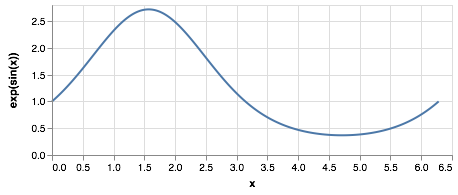

In [25]:
alt.Chart(df_graceful,
        height=150
    ).mark_line(
    ).encode(
        x='x:Q',
        y=alt.Y('y:Q', title='exp(sin(x))'),
        order='x:Q'
    )

### Some words on Vega/Vega-Lite

Altair is really an interface to [VegaLite](https://vega.github.io/vega-lite/). Vega-Lite is a powerful high-level grammar for graphics. It takes a plot specified in a JSON file and uses JavaScript to render the plot (interactively) in the browser. You can directly edit the JSON file of a Vega-Lite plot and see it update live in the [Vega/VegaLite editor](https://vega.github.io/editor/). This is a great way to share and manipulate your graphics, since you can copy a link to your graphic and all of the data from the underlying data frame is kept in the plot specification.

There are many reasons why using Vega-Lite is a good idea, and [this blog post](https://blog.usejournal.com/why-im-backing-vega-lite-as-our-default-tool-for-data-visualisation-51c20970df39) highlights many of them.

Remember that Vega-Lite is a high-level plotting software, which allows you to rapidly make beautiful plots directly from your data frame. Since Altair is a Python interface for Vega-Lite, it, too, is also high-level. This convenience comes at a price; it is harder to customize your plots. If you want to customize your Vega-Lite plots, you might need to dive into Vega, and if you want to customize further, you might need to hack some D3, which means writing JavaScript code. Note also that Vega-Lite plots can be bloated JSON files and the performance of rendering and interacting with the graphic can get poor as the size of the data set grows. Nonetheless, I think you will find that most of your plotting applications can be accomplished using Altair/Vega-Lite.

That said, we will definitely be needing some more customizability and performance in plotting, particularly when looking at images and results of MCMC sampling. For these purposes, we will use [Bokeh](https://bokeh.pydata.org/en/latest/).

## Plotting with Bokeh

To demonstrate how to use Bokeh for making plots, we will plot many of the same data sets as with Altair.

### Scatter plots

The pipeline for making a plot using Bokeh is to first specify the "canvas" on which you want to paint your data, and then "paint" your data. For example, if we wanted to make a scatter plot of the adhesive force versus impact force, we first think about what space it should occupy. Specifically, we want a figure that is in Cartesian coordinates 400 pixels high and 600 wide. Now, we can start thinking about what we want each axis in the plot to represent. We will say that the x-axis represents impact force and the y-axis adhesive force. So, the first thing we do is to make a figure we will work with. So far, the data are not involved at all in the plotting process.

In [26]:
p = bokeh.plotting.figure(height=300,
                          width=450,
                          x_axis_label='impact force (mN)',
                          y_axis_label='adhesive force (mN)')

The Bokeh plot is stored in a `bokeh.plotting.figure.Figure` object. We can continue to build the figure by adding the glyphs. To add dots to the figure, we use the `p.circle()` method. We specify the data source (`df`), and the columns we want to be the x and y variable.

In [27]:
p.circle(source=df,
         x='impact force (mN)',
         y='adhesive force (mN)')

bokeh.models.renderers.GlyphRenderer(
    id='369d18bc-4d0c-4bcd-a822-0c1859c0c790',
    data_source=bokeh.models.sources.ColumnDataSource(
        id='95335fd4-b8ad-4733-8ef4-478031fceb1d',
        callback=None,
        data={'ID': ['I',
          'I',
          'I',
          'I',
          'I',
          'I',
          'I',
          'I',
          'I',
          'I',
          'I',
          'I',
          'I',
          'I',
          'I',
          'I',
          'I',
          'I',
          'I',
          'I',
          'II',
          'II',
          'II',
          'II',
          'II',
          'II',
          'II',
          'II',
          'II',
          'II',
          'II',
          'II',
          'II',
          'II',
          'II',
          'II',
          'II',
          'II',
          'II',
          'II',
          'III',
          'III',
          'III',
          'III',
          'III',
          'III',
          'III',
          'III',
          'III',
          'III',
          'III',
          'III',
          'III',
          'III',
          'III',
          'III',
          'III',
          'III',
          'III',
          'III',
          'IV',
          'IV',
          'IV',
          'IV',
          'IV',
          'IV',
          'IV',
          'IV',
          'IV',
          'IV',
          'IV',
          'IV',
          'IV',
          'IV',
          'IV',
          'IV',
          'IV',
          'IV',
          'IV',
          'IV'],
         'date': ['2013_02_26',
          '2013_02_26',
          '2013_03_01',
          '2013_03_01',
          '2013_03_01',
          '2013_03_01',
          '2013_03_05',
          '2013_03_05',
          '2013_03_05',
          '2013_03_05',
          '2013_03_12',
          '2013_03_12',
          '2013_03_12',
          '2013_03_12',
          '2013_03_12',
          '2013_03_15',
          '2013_03_15',
          '2013_03_15',
          '2013_03_15',
          '2013_03_15',
          '2013_03_19',
          '2013_03_19',
          '2013_03_19',
          '2013_03_19',
          '2013_03_21',
          '2013_03_21',
          '2013_03_21',
          '2013_03_21',
          '2013_03_25',
          '2013_03_25',
          '2013_03_25',
          '2013_03_25',
          '2013_03_28',
          '2013_03_28',
          '2013_04_03',
          '2013_04_03',
          '2013_04_08',
          '2013_04_08',
          '2013_04_08',
          '2013_04_12',
          '2013_05_27',
          '2013_05_27',
          '2013_05_27',
          '2013_06_11',
          '2013_06_11',
          '2013_06_11',
          '2013_06_14',
          '2013_06_14',
          '2013_06_18',
          '2013_06_18',
          '2013_06_18',
          '2013_06_18',
          '2013_06_21',
          '2013_06_21',
          '2013_06_21',
          '2013_06_21',
          '2013_06_26',
          '2013_06_26',
          '2013_06_26',
          '2013_06_26',
          '2013_05_27',
          '2013_05_27',
          '2013_05_27',
          '2013_05_30',
          '2013_05_30',
          '2013_05_30',
          '2013_06_03',
          '2013_06_11',
          '2013_06_11',
          '2013_06_11',
          '2013_06_11',
          '2013_06_14',
          '2013_06_18',
          '2013_06_18',
          '2013_06_18',
          '2013_06_18',
          '2013_06_21',
          '2013_06_21',
          '2013_06_21',
          '2013_06_21'],
         'contact area without mucus (mm2)': [70,
          94,
          79,
          158,
          216,
          106,
          110,
          178,
          224,
          176,
          33,
          112,
          92,
          129,
          148,
          105,
          124,
          134,
          260,
          168,
          15,
          24,
          34,
          26,
          16,
          24,
          33,
          67,
          0,
          4,
          8,
          28,
          0,
          46,
          0,
          0,
          89,
  

Now notice that this returned a `GlyphRenderer` instance, which we still have to explicitly show if we want to look at it. To show the plot, we need to do this explicitly using `bokeh.io.show()`. How the plot is displayed varies. For display in a notebook using JupyterLab, you need to have the JupyterLab extension [jupyterlab_bokeh](https://github.com/bokeh/jupyterlab_bokeh) installed and you also need to execute `bokeh.io.output_notebook()` earlier in the notebook (as we have done here).

In [28]:
bokeh.io.show(p)

We can also add tooltips. The tooltips are given as a list of tuples. The first entry in each tuple is the text you want to use to label the displayed value. The second entry is a string starting with `@` to signify which column of the source data will be displayed. You can use braces `{}` for column names with spaces and for formatting strings.

In [29]:
# Make hover object
hover = bokeh.models.HoverTool(tooltips=[('ID', '@ID'), 
                                         ('impact time (ms)', '@{impact time (ms)}{0.2f}')])

# Add the hover tool to the plot
p.add_tools(hover)

bokeh.io.show(p)

If we want to color by age, like we did in our Altair examples, we need to do the DataFrame slicing by hand. You also need to explicitly connect the glyph with a legend string.

In [30]:
p = bokeh.plotting.figure(height=300,
                          width=450,
                          x_axis_label='impact force (mN)',
                          y_axis_label='adhesive force (mN)')

p.circle(source=df.loc[df['age']=='adult',:],
         x='impact force (mN)',
         y='adhesive force (mN)',
         legend='adult')

p.circle(source=df.loc[df['age']=='juvenile',:],
         x='impact force (mN)',
         y='adhesive force (mN)',
         legend='juvenile',
         color='orange')

bokeh.io.show(p)

You can make adjustments to plots by setting various attributes of the plot object itself. For example, to change the axis labels to boldface, you can do the following.

In [31]:
p.xaxis.axis_label_text_font_style = 'bold'
p.yaxis.axis_label_text_font_style = 'bold'

bokeh.io.show(p)

If we want to make subplots, we again must take a more verbose approach. As an example, we will make the same set of four plots we did in the example above demonstrating Altair's `repeat` capability. First, it is convenient to write a function to generate the scatter plots.

In [32]:
def scatter(df, x, y, p=None, color='#1f77b4', plot_height=250, plot_width=350):
    """Populate a figure with a scatter plot."""
    if p is None:
        p = bokeh.plotting.figure(plot_height=plot_height, 
                                  plot_width=plot_width, 
                                  x_axis_label=x,
                                  y_axis_label=y)
        
    p.circle(df[x], df[y], color=color)
    
    return p

Next, we make the step of plots we want, storing the plots in a list of lists that has the right 2 by 2 dimension of the finished plot.

In [33]:
row = ['impact force (mN)', 'adhesive force (mN)']
column = ['impact time (ms)', 'time frog pulls on target (ms)']

plots = [[scatter(df, x, y) for x in column] for y in row]

Next, we link the axes to enable appropriate zooming.

In [34]:
for k in [0, 1]:
    plots[k][1].y_range = plots[k][0].y_range
    plots[1][k].x_range = plots[0][k].x_range

Finally, we use `bokeh.layouts.gridplot()` to lay out the plots.

In [35]:
bokeh.io.show(bokeh.layouts.gridplot(plots, toolbar_location='right'))

### Line plots

We can similarly make a plot with lines. We'll do this for the voltage recording. When I do line plots in Bokeh, I almost always use the `line_join='bevel'` kwarg to avoid overly sharp spikes, which are a rendering artefact.

In [36]:
p = bokeh.plotting.figure(height=250,
                          width=550,
                          x_axis_label='time (ms)',
                          y_axis_label='V (µV)')

p.line(source=df_spike,
       x='t (ms)',
       y='V (uV)',
       line_join='bevel')

bokeh.io.show(p)

In Bokeh, you can also directly supply arrays for the values of `x` and `y`. This can be useful when you are concerned about how the points are ordered for joining with a line, since there is no `order` kwarg in Bokeh like in Altair.

In [37]:
p = bokeh.plotting.figure(height=250,
                          width=550,
                          x_axis_label='time (ms)',
                          y_axis_label='V (µV)')

p.line(x=df_spike['t (ms)'],
       y=df_spike['V (uV)'],
       line_join='bevel')

bokeh.io.show(p)

And finally, just for completeness, we'll make the plot of the graceful function.

In [38]:
p = bokeh.plotting.figure(height=250,
                          width=550,
                          x_axis_label='x',
                          y_axis_label='exp(sin(x))')

p.line(source=df_graceful,
       x='x',
       y='y',
       line_width=2,
       line_join='bevel')

bokeh.io.show(p)

## Displaying images

Both Bokeh and Altair offer means to display images. However, Bokeh's performance is **far** better than Altair's. That said, I will quickly demonstrate how to display an image using Altair. 

### Displaying images using Altair

For our purposes now, we will use a manufactured image. Here, `z` is the "intensity" of the image.

In [39]:
# Make false image
x, y = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
z = np.exp(np.sin(x)*np.cos(x*y))

To display an image using Altair, we need to convert the image to a tidy data frame.

In [40]:
# Convert this grid to columnar data expected by Altair
data = pd.DataFrame({'x': x.ravel(),
                     'y': y.ravel(),
                     'z': z.ravel()})

Finally, we can use the rectangle marker with color encoded by the z (intensity) value of the image. We will use a color scheme of `'greys`' to encode for the color.

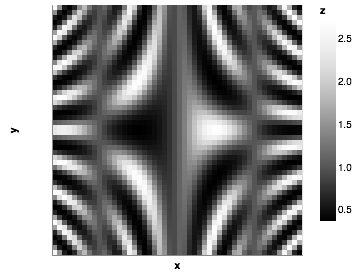

In [41]:
alt.Chart(data
    ).mark_rect(
    ).encode(
        x=alt.X('x:O',
                axis=alt.Axis(labels=False, ticks=False),
                scale=alt.Scale(padding=0)),
        y=alt.Y('y:O',
                axis=alt.Axis(labels=False, ticks=False),
                scale=alt.Scale(padding=0)),
        color=alt.Color('z:Q', scale=alt.Scale(scheme='greys'), sort='descending')
    ).properties(
        width=250,
        height=250
    )

Bokeh has [native support for images](https://bokeh.pydata.org/en/latest/docs/user_guide/plotting.html#images), but there are some troublesome details to take care of. 
- You need to specify the `x_range` and `y_range` kwargs when making the figure to make the image fill the figure.
- You need to specify the anchor point of the image (where the lower-left corner sits on your axes). These are specified with the `x` and `y` args of `p.image()`.
- You need to specify the width and height the image takes on the axes using the `dw` and `dh` args of `p.image()`.
- Like Altair, you need to supply a mapping of color to intensity. You can do that using `bokeh.models.LinearColorMapper`.

In [42]:
# Set up color mapper
color_mapper = bokeh.models.LinearColorMapper(bokeh.palettes.grey(256))

# Set up plot, specifying dimension
p = bokeh.plotting.figure(plot_height=250,
                          plot_width=250,
                          x_range=[x.min(), x.max()],
                          y_range=[y.min(), y.max()],
                          x_axis_label='x',
                          y_axis_label='y')

p.image(image=[z],
        x=x.min(), 
        y=y.min(), 
        dw=x.max()-x.min(), 
        dh=y.max()-y.min(),
        color_mapper=color_mapper)

bokeh.io.show(p)

This can be a bit cumbersome. To help with that, I have included a image viewing function in the [`bebi103` module](https://github.com/justinbois/bebi103).

In [43]:
bokeh.io.show(bebi103.viz.imshow(z, 
                                 color_mapper=color_mapper,
                                 colorbar=True,
                                 x_axis_label='x',
                                 y_axis_label='y'))

Note that because I did not specify the `x_range` and `y_range`, the default values of the axis are in units of pixels, starting at zero. If I specify those, I can get the axes back.

In [44]:
bokeh.io.show(bebi103.viz.imshow(z, 
                                 color_mapper=color_mapper,
                                 colorbar=True,
                                 x_range=[x.min(), x.max()],
                                 y_range=[y.min(), y.max()],
                                 x_axis_label='x',
                                 y_axis_label='y'))

We will talk a lot more about image display in coming weeks when we start working with images.

## Computing environment

In [45]:
%load_ext watermark

In [46]:
%watermark -v -p numpy,pandas,altair,bokeh,bebi103,jupyterlab

CPython 3.7.0
IPython 6.5.0

numpy 1.15.1
pandas 0.23.4
altair 2.2.2
bokeh 0.13.0
bebi103 0.0.23
jupyterlab 0.34.9
